**Import Libraries**

In [1]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import timm

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [2]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42
NUM_WORKERS =32

# Parameteres training
LEARNING_RATE = 0.01
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 12
BATCH_SIZE = 32
LEARNING_RATE_SCHEDULER_PATIENCE = 3
OPTIMIZER_STEP_SIZE = 1
OPTIMIZER_GAMMA = 0.5

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [3]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [4]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [5]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [6]:
# Split based on patients
unique_patients = labels_df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = labels_df[labels_df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = labels_df[labels_df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [7]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [8]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [9]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [10]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [11]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = timm.create_model('maxxvitv2_rmlp_base_rw_224.sw_in12k_ft_in1k', pretrained=True)

        # Replace the classification head to match the number of disease labels
        self.base_model.head.fc = nn.Linear(self.base_model.head.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)

# Initialize the Model
model = MultiLabelClassifier()
model.to(device)

MultiLabelClassifier(
  (base_model): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): LayerNormAct2d(
        (64,), eps=1e-06, elementwise_affine=True
        (drop): Identity()
        (act): GELU()
      )
      (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MaxxVitBlock(
            (conv): ConvNeXtBlock(
              (shortcut): Downsample2d(
                (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
                (expand): Identity()
              )
              (down): Identity()
              (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), groups=128)
              (norm): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
              (mlp): ConvMlp(
                (fc1): Conv2d(128, 512, kernel_size

**Use Multiple GPUs**

In [12]:
model = nn.DataParallel(model)

# **Step 4: Train the Model**

**Step 1: Train Classification Head Only**

In [13]:
# Freeze the backbone parameters
for name, param in model.named_parameters():
    if "head.fc" not in name:
        param.requires_grad = False

In [14]:
# Only the classifier parameters will be updated
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer_head, step_size=OPTIMIZER_STEP_SIZE, gamma=OPTIMIZER_GAMMA)

In [15]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler once per epoch.
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience} epochs")
                model.load_state_dict(torch.load('best_model.pt', weights_only=True))
                break

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_head, LEARNING_RATE_SCHEDULER_PATIENCE, EPOCHS)

Epoch 1/12: 100%|██████████| 351/351 [00:23<00:00, 15.12it/s, Loss=0.231] 


Epoch 1/12 | Training Loss: 0.2319 | Validation Loss: 0.2307 | Mean Validation AUC: 0.6977
New best model saved with Mean Validation AUC: 0.6977


Epoch 2/12: 100%|██████████| 351/351 [00:21<00:00, 16.18it/s, Loss=0.181] 


Epoch 2/12 | Training Loss: 0.1932 | Validation Loss: 0.1918 | Mean Validation AUC: 0.7130
New best model saved with Mean Validation AUC: 0.7130


Epoch 3/12: 100%|██████████| 351/351 [00:21<00:00, 16.20it/s, Loss=0.137] 


Epoch 3/12 | Training Loss: 0.1769 | Validation Loss: 0.1694 | Mean Validation AUC: 0.7357
New best model saved with Mean Validation AUC: 0.7357


Epoch 4/12: 100%|██████████| 351/351 [00:22<00:00, 15.91it/s, Loss=0.141] 


Epoch 4/12 | Training Loss: 0.1691 | Validation Loss: 0.1666 | Mean Validation AUC: 0.7396
New best model saved with Mean Validation AUC: 0.7396


Epoch 5/12: 100%|██████████| 351/351 [00:22<00:00, 15.60it/s, Loss=0.139] 


Epoch 5/12 | Training Loss: 0.1647 | Validation Loss: 0.1652 | Mean Validation AUC: 0.7418
New best model saved with Mean Validation AUC: 0.7418


Epoch 6/12: 100%|██████████| 351/351 [00:22<00:00, 15.53it/s, Loss=0.139] 


Epoch 6/12 | Training Loss: 0.1625 | Validation Loss: 0.1645 | Mean Validation AUC: 0.7448
New best model saved with Mean Validation AUC: 0.7448


Epoch 7/12: 100%|██████████| 351/351 [00:21<00:00, 16.14it/s, Loss=0.14]  


Epoch 7/12 | Training Loss: 0.1613 | Validation Loss: 0.1627 | Mean Validation AUC: 0.7465
New best model saved with Mean Validation AUC: 0.7465


Epoch 8/12: 100%|██████████| 351/351 [00:21<00:00, 16.29it/s, Loss=0.137] 


Epoch 8/12 | Training Loss: 0.1607 | Validation Loss: 0.1623 | Mean Validation AUC: 0.7466
New best model saved with Mean Validation AUC: 0.7466


Epoch 9/12: 100%|██████████| 351/351 [00:22<00:00, 15.78it/s, Loss=0.134] 


Epoch 9/12 | Training Loss: 0.1604 | Validation Loss: 0.1621 | Mean Validation AUC: 0.7469
New best model saved with Mean Validation AUC: 0.7469


Epoch 10/12: 100%|██████████| 351/351 [00:22<00:00, 15.42it/s, Loss=0.137] 


Epoch 10/12 | Training Loss: 0.1604 | Validation Loss: 0.1620 | Mean Validation AUC: 0.7469


Epoch 11/12: 100%|██████████| 351/351 [00:22<00:00, 15.85it/s, Loss=0.136] 


Epoch 11/12 | Training Loss: 0.1602 | Validation Loss: 0.1619 | Mean Validation AUC: 0.7469
New best model saved with Mean Validation AUC: 0.7469


Epoch 12/12: 100%|██████████| 351/351 [00:22<00:00, 15.34it/s, Loss=0.136] 


Epoch 12/12 | Training Loss: 0.1601 | Validation Loss: 0.1620 | Mean Validation AUC: 0.7469
New best model saved with Mean Validation AUC: 0.7469


**Step 2: Fine Tune Entire Network**

In [16]:
# Unfreeze all layers for fine tuning
for param in model.parameters():
    param.requires_grad = True

In [17]:
# Use a lower learning rate for the whole network
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = optim.lr_scheduler.StepLR(optimizer_full, step_size=OPTIMIZER_STEP_SIZE, gamma=OPTIMIZER_GAMMA)

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Update the scheduler once per epoch.
        scheduler.step()

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"New best model saved with Mean Validation AUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping. No improvement for {patience:.4f} epochs")
                model.load_state_dict(torch.load('best_model.pt', weights_only=True))
                break

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_full, LEARNING_RATE_SCHEDULER_PATIENCE, EPOCHS)

Epoch 1/12: 100%|██████████| 351/351 [00:22<00:00, 15.37it/s, Loss=0.116] 


Epoch 1/12 | Training Loss: 0.1595 | Validation Loss: 0.1462 | Mean Validation AUC: 0.8326
New best model saved with Mean Validation AUC: 0.8326


Epoch 2/12: 100%|██████████| 351/351 [00:23<00:00, 14.72it/s, Loss=0.112] 


Epoch 2/12 | Training Loss: 0.1432 | Validation Loss: 0.1428 | Mean Validation AUC: 0.8476
New best model saved with Mean Validation AUC: 0.8476


Epoch 3/12: 100%|██████████| 351/351 [00:23<00:00, 14.97it/s, Loss=0.124] 


Epoch 3/12 | Training Loss: 0.1347 | Validation Loss: 0.1403 | Mean Validation AUC: 0.8527
New best model saved with Mean Validation AUC: 0.8527


Epoch 4/12: 100%|██████████| 351/351 [00:21<00:00, 16.12it/s, Loss=0.11]  


Epoch 4/12 | Training Loss: 0.1257 | Validation Loss: 0.1411 | Mean Validation AUC: 0.8511


Epoch 5/12: 100%|██████████| 351/351 [00:22<00:00, 15.91it/s, Loss=0.118] 


Epoch 5/12 | Training Loss: 0.1170 | Validation Loss: 0.1458 | Mean Validation AUC: 0.8436


Epoch 6/12: 100%|██████████| 351/351 [00:23<00:00, 15.16it/s, Loss=0.127] 


Epoch 6/12 | Training Loss: 0.1102 | Validation Loss: 0.1530 | Mean Validation AUC: 0.8351
Early stopping. No improvement for 3.0000 epochs


# **Step 5: Evaluate the Model**

In [19]:
# TTA transforms
tta_transforms = [
    lambda img: img,
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

In [20]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set:  44%|████▍     | 310/697 [00:49<00:58,  6.57it/s]

Evaluating on Test Set: 100%|██████████| 697/697 [01:48<00:00,  6.43it/s]


**Compute Metrics for Each Label**

In [21]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.905939,0.176031,0.834659
Consolidation,0.957298,0.000000,0.820854
Infiltration,0.815107,0.189221,0.727096
Pneumothorax,0.953620,0.259312,0.888205
Edema,0.979367,0.008621,0.893934
Emphysema,0.977034,0.353535,0.941089
Fibrosis,0.983493,0.021277,0.821820
Effusion,0.897551,0.484424,0.885414
Pneumonia,0.986813,0.000000,0.765319
Pleural_Thickening,0.970396,0.000000,0.809617


**Plot ROC curves for each label**

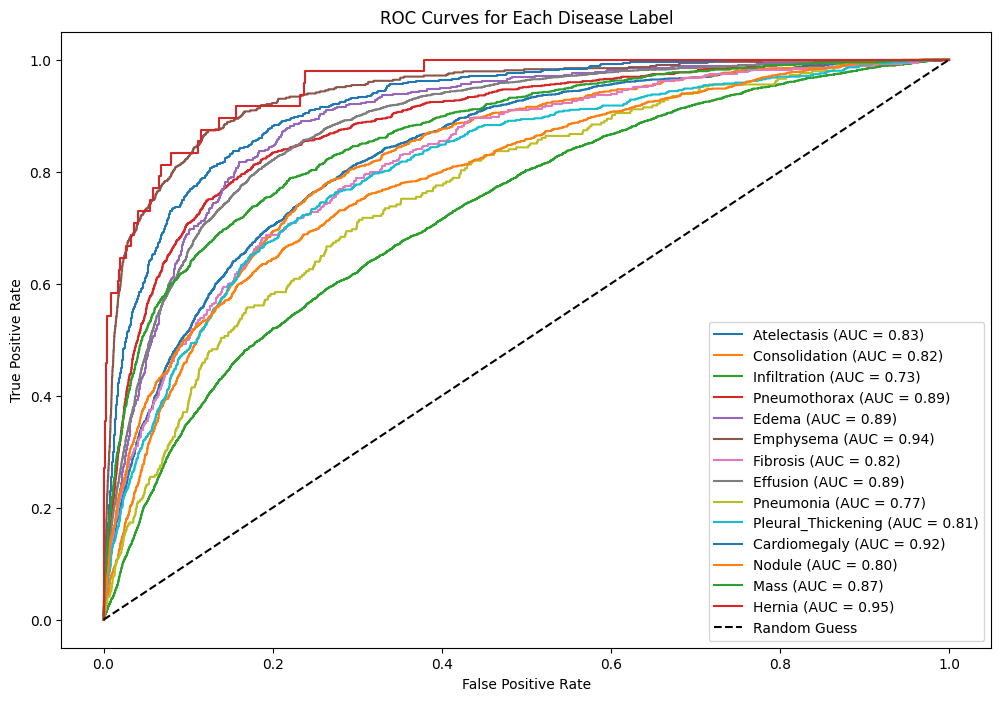

In [22]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

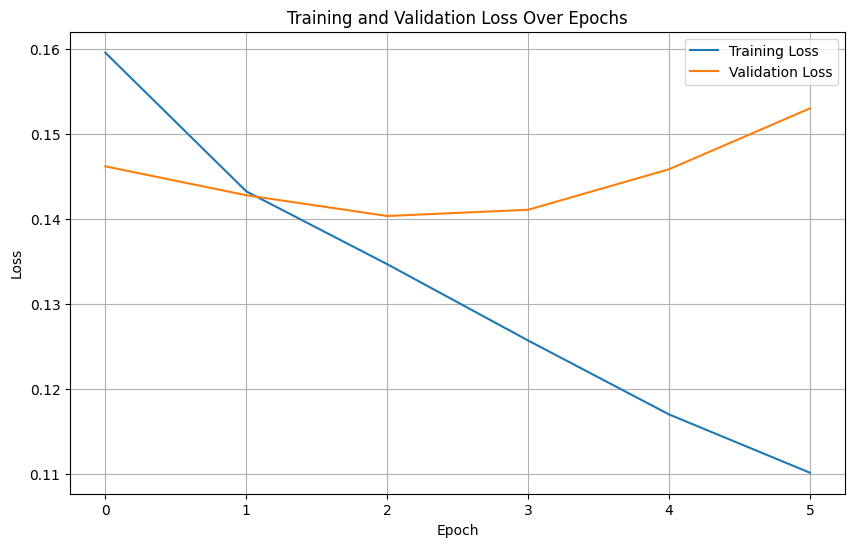

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

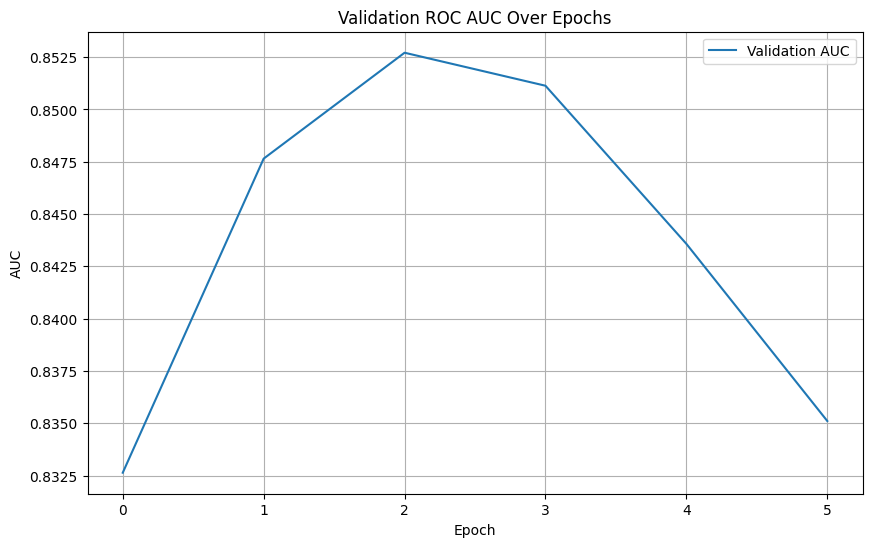

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()